In [1]:
from fastbook import * #ddg 이용 시 필요
from fastai.vision.widgets import * #위젯 이용 시 필요
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [2]:
#1단계는 데이터 수집이야.
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')
#상위 폴더를 만들 경로를 먼저 지정해.

if not path.exists():
    path.mkdir() #그 경로를 상위 폴더로 만들어. (그래야 bears폴더에 grizzly가 들어갈 수 있어.)
for o in bear_types:
    dest = (path/o) #폴더를 만들 경로를 먼저 지정해.
    dest.mkdir(exist_ok=True) #그 경로를 폴더로 만들어. (그래야 grizzly폴더에 곰 사진들이 들어갈 수 있어.)
    results = search_images_ddg(f'{o} bear') #이미지를 검색해.
    download_images(dest, urls=results) #경로에 urls를 다운로드해.

In [3]:
fns = get_image_files(path)
#fns는 path 폴더 안의 모든 파일들을 담은 리스트야. (파일 예시: Path('bears'/'black'/0095.jpg))
failed = verify_images(fns)
#failed는 fns 안의 오류 파일을 찾아서 담은 리스트야.
failed.map(Path.unlink)
#failed의 각 항목, 즉 오류파일들을 삭제해.

(#27) [None,None,None,None,None,None,None,None,None,None...]

In [5]:
#2단계는 데이터를 구성하는거야.
#데이터들을 적절히 구성해서 dataloaders을 만들어야 해.
#바로 dataloaders를 만들 수도 있지만,
#이번엔 템플릿 같은 datablock으로 세심하게 세부사항을 설정하고나서 dataloaders를 만들 거야.

bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #1)입출력 데이터의 유형을 지정해.
    get_items=get_image_files, #2)데이터 파일을 가져오는 방법을 지정해.
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #3)검증용 데이터를 나누는 방법.
    get_y=parent_label,#4)레이블을 지정하는 방법을 지정해.
    item_tfms=Resize(128)#5)이미지 변형 방법을 지정해.
)

In [6]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
#데이터블럭 bears를 새롭게 변경할거야.
#아이템 단위의 변형으로는 랜덤으로 이미지를 자르는 변형을 추가하고,
#배치 단위의 변형으로는 회전이나 비틀기 같은 변형을 추가할거야.
#배치 단위 변형은 배치 내의 모든 이미지에 일괄적으로 동일한 변형을 주는 거야. 

In [7]:
dls = bears.dataloaders(path)
#이제 datablock이 완성되었으니,
#핵심인 데이터 path를 넣어주고 dataloaders를 만들어.

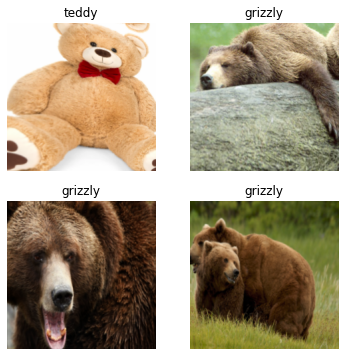

In [8]:
dls.train.show_batch(max_n=4) #배치 미리보기.

In [9]:
#3단계는 학습을 하는 거야. 학습기를 만들고, 학습을 진행해.
learn = vision_learner(dls, resnet18, metrics=error_rate)
#간단한 이미지 분류 작업을 수행할 때는 cnn_learner를 사용하고,
#좀 더 복잡한 컴퓨터 비전 작업을 할 때는 vision_learner를 사용해.

learn.fine_tune(4)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.305285,0.137699,0.045872,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.153491,0.152881,0.027523,00:08
1,0.129559,0.154703,0.027523,00:08
2,0.114226,0.141420,0.018349,00:08
3,0.092152,0.131994,0.036697,00:08


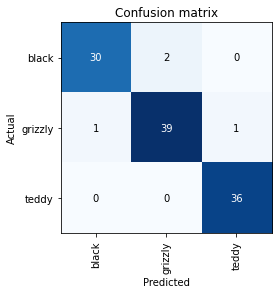

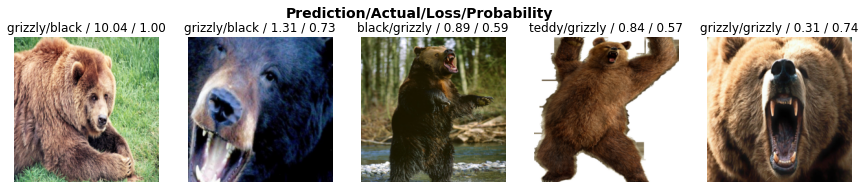

In [10]:
#4단계는 이미지를 말끔히 정리하는 거야.
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
#오차행렬은 어디에서 예측이 틀렸는지를 시각적으로 보여줘.

interp.plot_top_losses(5, nrows=1)
#가장 손실이 높은 이미지를 보여줘

In [11]:
cleaner = ImageClassifierCleaner(learn)
cleaner
#ImageClassifierCleaner는 간단히 이미지 정리를 도와주는 fastai함수야.
#오류가 난 이미지를 삭제하거나 변경할 이미지를 선택해.
#여기서 반환되는 인덱스를 이용해서, 뒤의 코드에서 실제로 삭제와 이동을 할거야.

In [13]:
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()
#삭제목록 인덱스를 이용해서 해당 이미지의 경로를 삭제해.

for idx, cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/cat)
#이동목록 인덱스와 카테고리를 이용해서 해당이미지의 경로를 이동시켜.

In [14]:
#5단계는 모델을 앱으로 전환하는 거야.
learn.export()
#모델을 파일로 export해.

learn_inf = load_learner('export.pkl')
#추론용 러너를 만들어.

In [15]:
#지금부터는 앱 화면에 나타나게 될 위젯을 만들 거야.
#업로드버튼, 이미지위젯, 결과레이블위젯, 분류실행버튼을 만들 거야.

btn_upload = widgets.FileUpload()
#1) 추론할 이미지를 업로드 할 FileUpload 위젯을 만들어.
out_pl = widgets.Output()
#2) 해당 이미지를 화면에 표시하는 Output 위젯을 만들어.
lbl_pred = widgets.Label()
#3) 예측 결과를 표시하는 Label 위젯을 만들어.
btn_run = widgets.Button(description='Classify')
#4) 이미지 분류를 요청하는 Button 위젯을 만들어. 여기서는 'Classify'라는 버튼이 생성될 거야.

In [16]:
#지금까지 만든 위젯의 설정을 정의하는 함수를 만들거야.
#‘Classify' 버튼을 누르면 이 함수가 실행되어 위젯 설정이 이루어질거야.
#결과적으로는 화면에 설정이 완료된 위젯이 나타날거야.

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    #위젯으로 업로드한 이미지를 가지고 와.
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128, 128))
    #out_pl을 설정해.
    #이미지를 128*128크기로 표시하도록 설정해.
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    #lbl_pl을 설정해.
    #추론결과를 예측레이블과 확률로 나타내도록 설정해.

In [17]:
btn_run.on_click(on_click_classify)
#btn_run 을 클릭하면, 즉 'Classify'버튼을 누르면 이 함수가 실행되도록 해.

In [18]:
VBox([widgets.Label('Select your bear!'), btn_upload, btn_run, out_pl, lbl_pred])
#VBox(수직상자)에 위젯들을 나열하여서 셀 내에 위젯을 배치해.